# Análisis y procesamiento de señales - Trabajo semanal Nº 7
# Aramayo Yohana Valentina #

In [3]:
import sympy as sp
import numpy as np
import scipy.signal as sig
from scipy.signal.windows import hamming, kaiser, blackmanharris
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla, group_delay
def visualizar_ecg_por_tipo(ecg_original, ecg_filtrados, etiquetas, fs=1000, demora=0,
                            regs_interes=None, titulo='', mostrar=1, axs=None):
    import matplotlib.pyplot as plt
    colores_por_filtro = {
        'ventana': 'pink',
        'remez': 'purple',
        'firls': 'seagreen',
        'butter': 'indigo',
        'iir': 'darkred',
        'fft': 'purple'
    }

    if regs_interes is None:
        regs_interes = (
            [4000, 5500],
            [10e3, 11e3],
            np.array([5, 5.2]) * 60 * fs,
            np.array([12, 12.4]) * 60 * fs,
            np.array([15, 15.2]) * 60 * fs,
        )

    if isinstance(demora, int):
        demora = [demora] * len(ecg_filtrados)

    N = len(ecg_original)
    figs = []

    crear_figura = axs is None
    if axs is not None:
        if not isinstance(axs, (list, np.ndarray)):
            axs = [axs]
        elif len(regs_interes) == 1:
            axs = [axs[0]]  # Asegura que sea lista para iterar

    for idx, ii in enumerate(regs_interes):
        zoom_region = np.arange(int(max(0, ii[0])), int(min(N, ii[1])), dtype='uint')

        if crear_figura:
            fig, ax = plt.subplots(figsize=(10, 4))
        else:
            ax = axs[idx]
            fig = ax.figure

        ax.plot(zoom_region, ecg_original[zoom_region], label='ECG original', linewidth=1.5, color='gray')

        for i, etiqueta in enumerate(etiquetas):
            dr = demora[i] if i < len(demora) else 0
            color = colores_por_filtro.get(etiqueta.lower(), 'black')
            shift_indices = zoom_region + dr
            shift_indices = shift_indices[shift_indices < len(ecg_filtrados[i])]
            ax.plot(shift_indices, ecg_filtrados[i][shift_indices], label=etiqueta.capitalize(), color=color, linewidth=1.5)

        ax.set_title(f'{titulo} - Región: {int(ii[0])} a {int(ii[1])}')
        ax.set_ylabel('Amplitud [adim]')
        ax.set_xlabel('Muestras (#)')
        ax.legend()
        ax.grid(True)
        fig.tight_layout()

        figs.append(fig)

    if mostrar == 1 and crear_figura:
        for f in figs:
            f.show()
    else:
        return figs

# ==============================
# CARGAR ECG
# ==============================

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
demora=200
# Frecuencia de muestreo
fs = 1000
nyquist = fs / 2


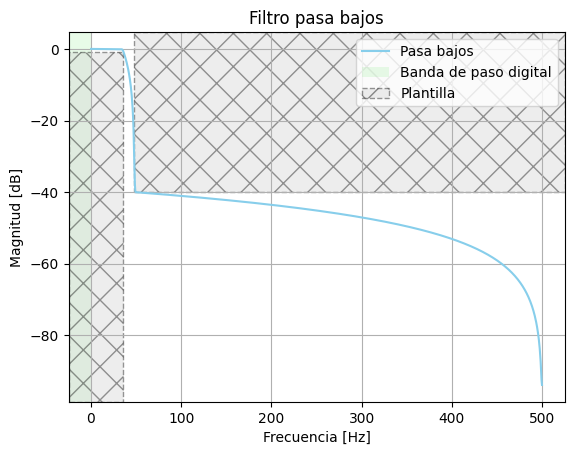

In [4]:
# ==============================
# DISEÑO DEL FILTRO PASA BAJOS
# ==============================
# Tamaño de los filtros
cant_coef_lp = 2001
cant_coef_hp = 5301
filter_type = 'lowpass'
fpass_lp = 35  # Hz
fstop_lp = 48  # Hz con esto llega a atenuar bien a 50 hz
ripple = 0.1   # dB
attenuation = 40  # dB

frecs_lp = [0.0, fpass_lp, fstop_lp, nyquist]
gains_db_lp = [0, -ripple, -attenuation, -100]
gains_lp = 10**(np.array(gains_db_lp)/20)

num_lp = sig.firwin2(cant_coef_lp, frecs_lp, gains_lp, window=('kaiser', 14), fs=fs)

# Visualización del pasa bajos
w_rad = 2 * np.pi * np.linspace(0.1, nyquist, 1000) / fs
w, hh_lp = sig.freqz(num_lp, worN=w_rad)

plt.figure(1)
plt.plot(w / np.pi * fs / 2, 20 * np.log10(np.abs(hh_lp) + 1e-15), label='Pasa bajos', color='skyblue')
plot_plantilla(filter_type='lowpass', fpass=fpass_lp, ripple=1, fstop=fstop_lp, attenuation=attenuation)
plt.title('Filtro pasa bajos')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

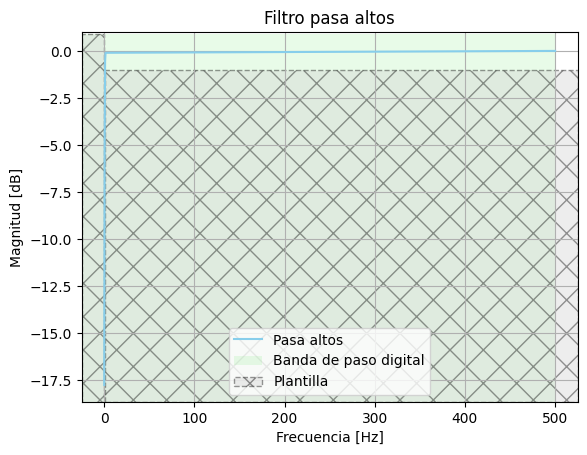

In [5]:
# ==============================
# DISEÑO DEL FILTRO PASA ALTOS
# ==============================

filter_type = 'highpass'
fstop_hp = 0.1  # Hz
fpass_hp = 1.0  # Hz

frecs_hp = [0.0, fstop_hp, fpass_hp, nyquist]
gains_db_hp = [-np.inf, -attenuation, -ripple, 0]
gains_hp = 10**(np.array(gains_db_hp)/20)

num_hp = sig.firwin2(cant_coef_hp, frecs_hp, gains_hp, window=('kaiser', 14), fs=fs)

# Visualización del pasa altos
w, hh_hp = sig.freqz(num_hp, worN=w_rad)

plt.figure(2)
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(np.abs(hh_hp) + 1e-15), label='Pasa altos', color='skyblue')
plot_plantilla(filter_type='highpass', fpass=fpass_hp, ripple=1, fstop=fstop_hp, attenuation=attenuation, fs=fs)
plt.title('Filtro pasa altos')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(which='both', axis='both')
plt.legend()
plt.show()


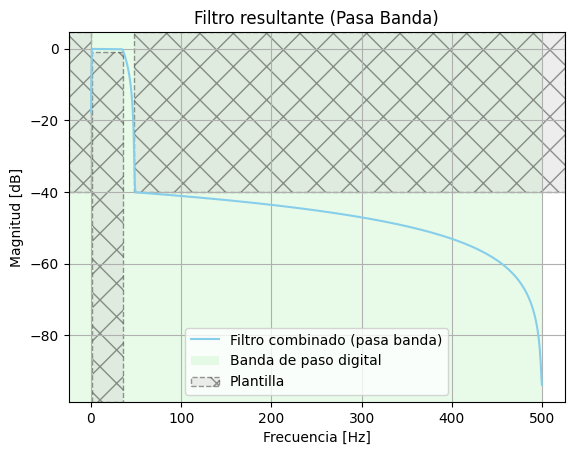

In [6]:
# ==============================
# CONVOLUCIÓN: FILTRO PASA BANDA
# ==============================

num_total = np.convolve(num_lp, num_hp)
w, h_total = sig.freqz(num_total, worN=w_rad)

plt.figure(3)
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(np.abs(h_total) + 1e-15), label='Filtro combinado (pasa banda)', color='skyblue')
plot_plantilla(filter_type='bandpass', fpass=(fpass_hp, fpass_lp), ripple=1, fstop=(fstop_hp, fstop_lp), attenuation=attenuation, fs=fs)
plt.title('Filtro resultante (Pasa Banda)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

Agregar respuesta de fase y modulo de pasabanda 

C:\Users\Vale\AppData\Local\Temp\ipykernel_2092\1766690519.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


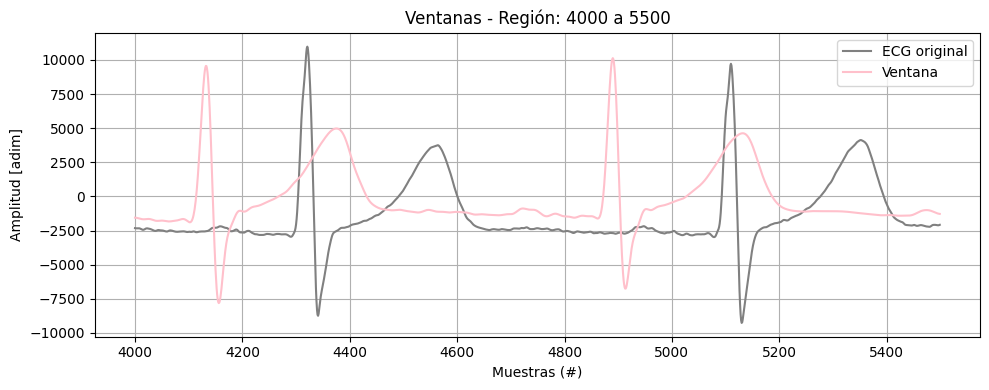

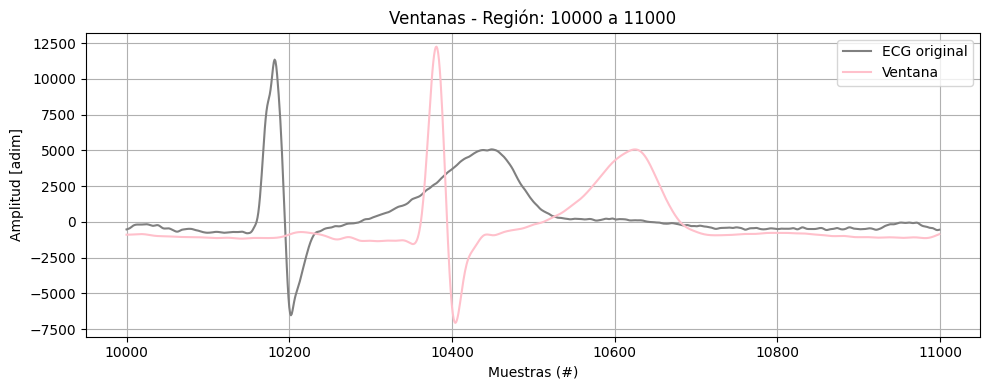

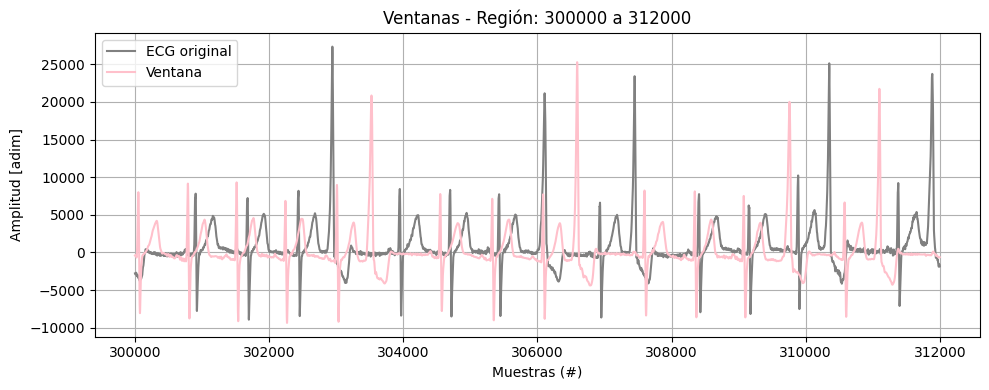

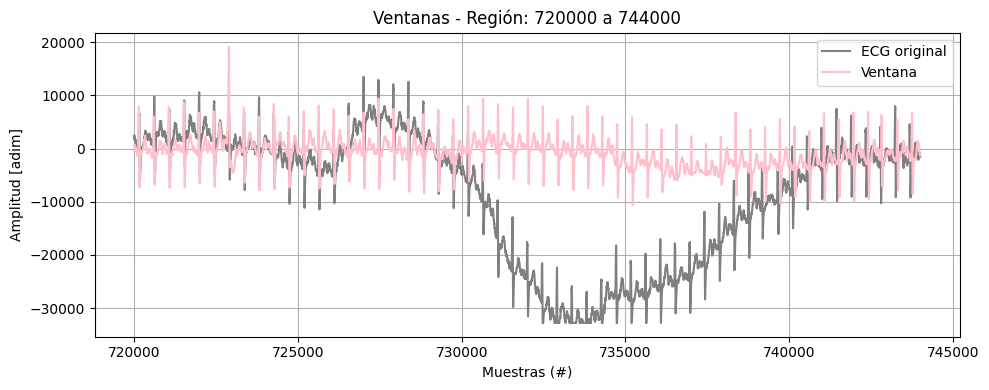

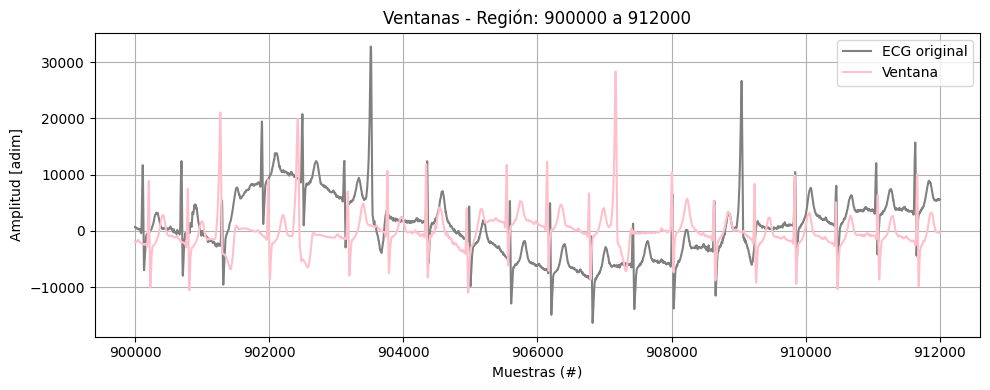

In [7]:
# ==============================
# FILTRADO CON VENTANA
# ==============================

ecg_filtrado_window = sig.lfilter(num_total, 1, ecg_one_lead) #1 porque es un filt
# plt.plot(ecg_filtrado)
# plt.plot(ecg_one_lead)
visualizar_ecg_por_tipo(
    ecg_original=ecg_one_lead,
    ecg_filtrados=[ecg_filtrado_window],
    etiquetas=['ventana'],
    demora=[0],
    titulo='Ventanas'
)


In [16]:
# %%
# cargo valores para cuadrados minimos y remez
# frecuencia de muestreo normalizada
fs = 1000
nyquist=fs/2
# tamaño de la respuesta al impulso
cant_coef = 1501 #explicar pq van coeficientes impares
filter_type = 'bandpass'

fpass = np.array([1., 35.])   
fstop = np.array([.1, 50.])  
ripple = 0.5 # dB
attenuation = 40 # dB

# construyo la plantilla de requerimientos
f = np.array([0, fstop[0], fpass[0], fpass[1], fpass[1]+1, nyquist]) # fpass[1]+1
hh = np.array([0, 0, 1, 1, 0, 0])

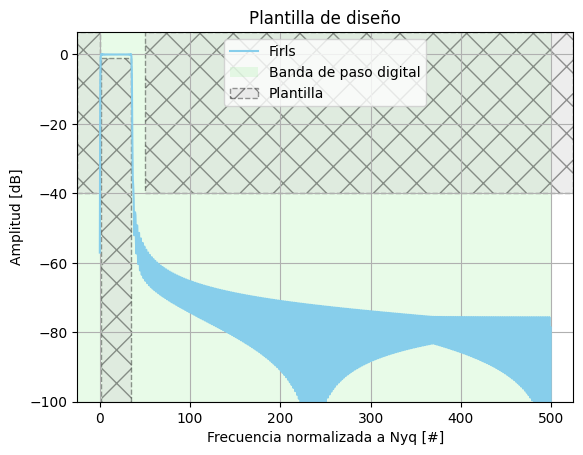

In [27]:
# %%
   # CUADRADOS MÍNIMOS
# Diseño del filtro
Filtro_cuadrado= sig.firls(numtaps = 1501, bands = f, desired = hh, fs = 1000)
# Es necesario tener orden impar!! Estudiar esto de los filtros fir
npoints=1000
# hh = sig.firls(numtaps = 1501, bands = f, desired = hh, fs = 1000)
w, hh_firls = sig.freqz(Filtro_cuadrado, worN=npoints) # <interpoló> los puntos obtenidos

plt.figure()
plt.plot(w/np.pi * fs / 2, 20*np.log10(np.abs(hh_firls )+1e-15), label='Firls', color='skyblue')

plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

plot_plantilla(filter_type='bandpass', fpass=(fpass[0], fpass[1]), ripple=1, fstop=(fstop[0], fstop[1]), attenuation=attenuation, fs=fs)
plt.legend()
plt.show()

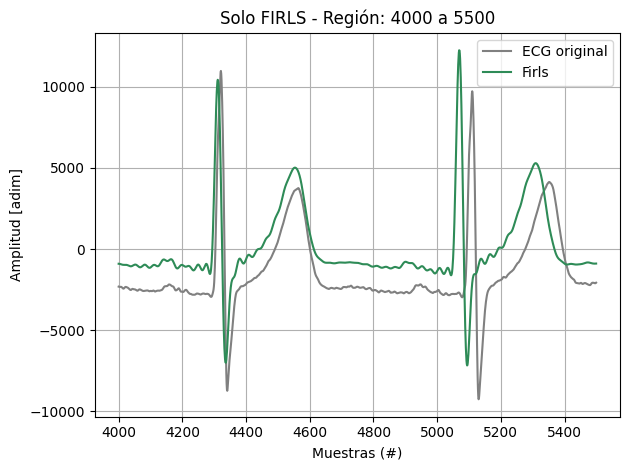

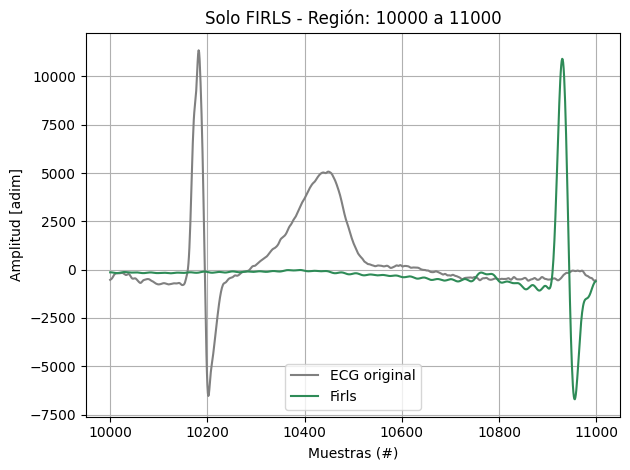

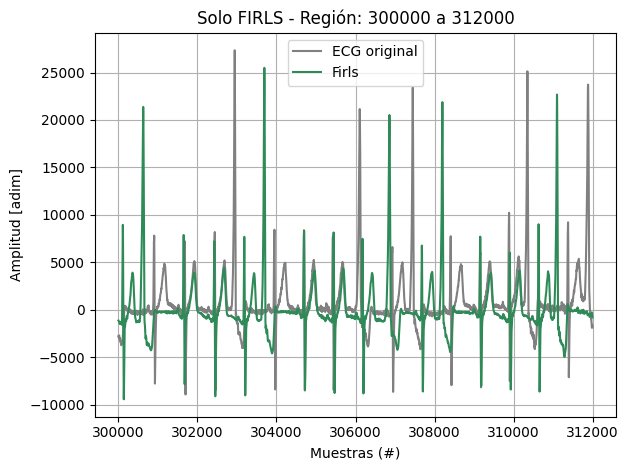

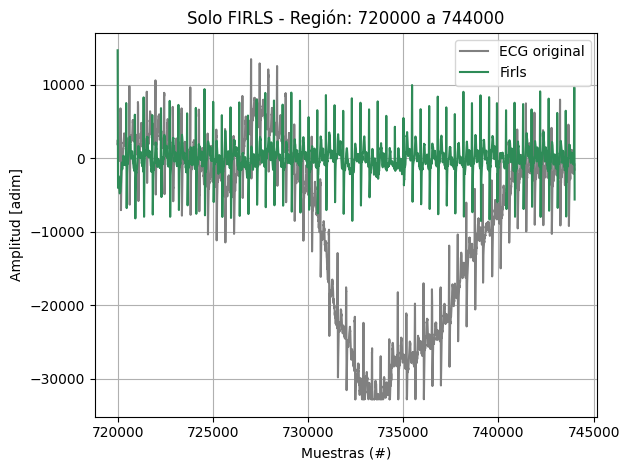

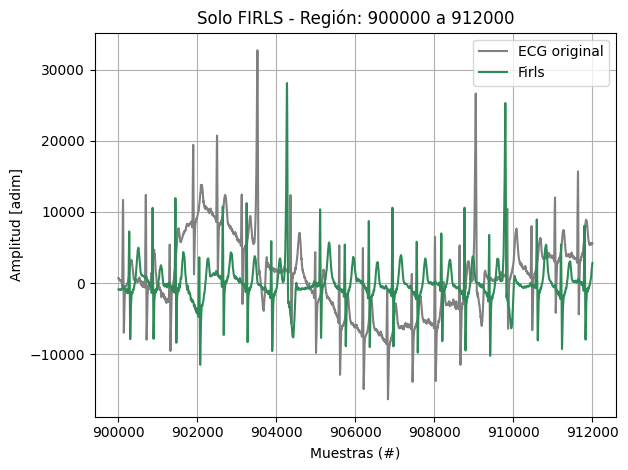

In [17]:
#VER GRAFICOS
ecg_filtrado_cuadrado = sig.lfilter(Filtro_cuadrado, 1, ecg_one_lead)
visualizar_ecg_por_tipo(
    ecg_original=ecg_one_lead,
    ecg_filtrados=[ecg_filtrado_cuadrado],
    etiquetas=['firls'],
    demora=[0],
    titulo='Solo FIRLS'
)

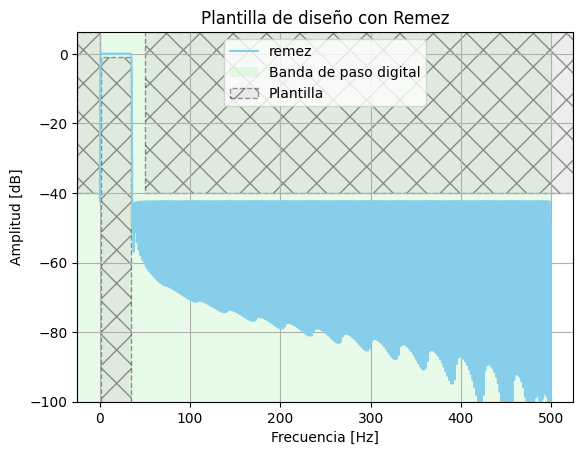

In [26]:
# %%
# PM - REMEZ
# # Diseño del filtro
Filtro_remez = sig.remez(numtaps = 2501, bands = f, desired=hh[::2], fs = 1000)
w, hh_remez = sig.freqz(Filtro_remez, worN=npoints)
plt.figure()
plt.plot(w / np.pi * fs / 2, 20 * np.log10(np.abs(hh_remez) + 1e-15), label='remez', color= 'skyblue')
plt.title('Plantilla de diseño con Remez')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type='bandpass', fpass=(fpass[0], fpass[1]), ripple=1, fstop=(fstop[0], fstop[1]), attenuation=attenuation, fs=fs)
plt.legend()
plt.show()

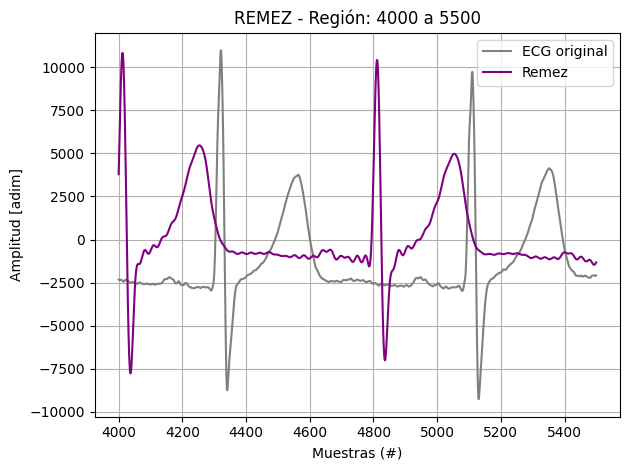

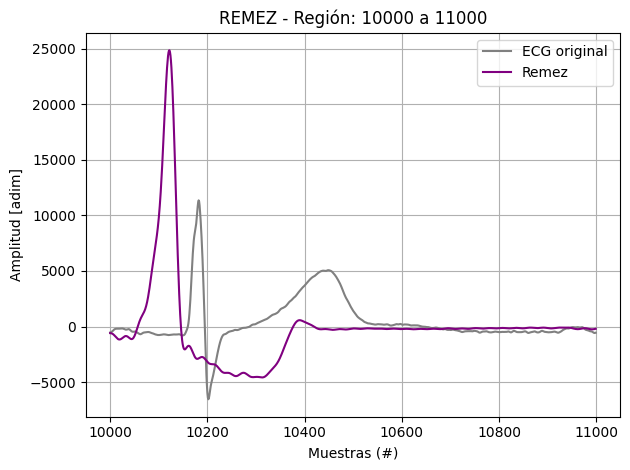

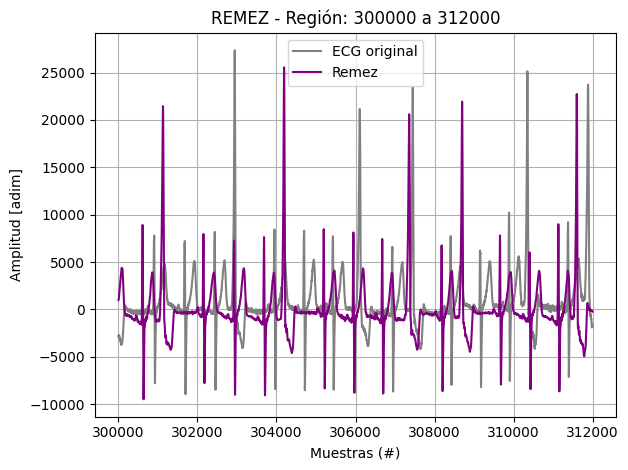

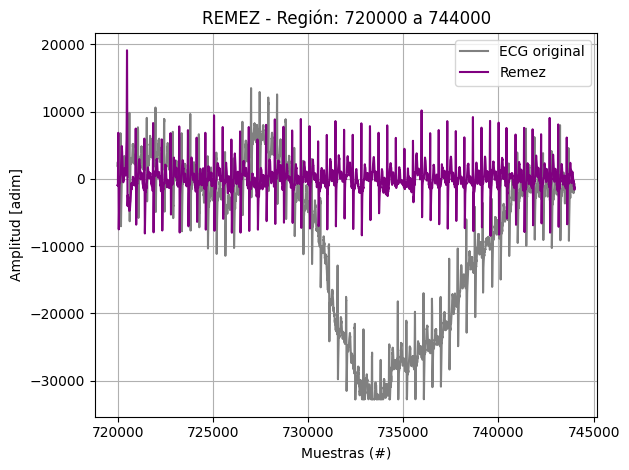

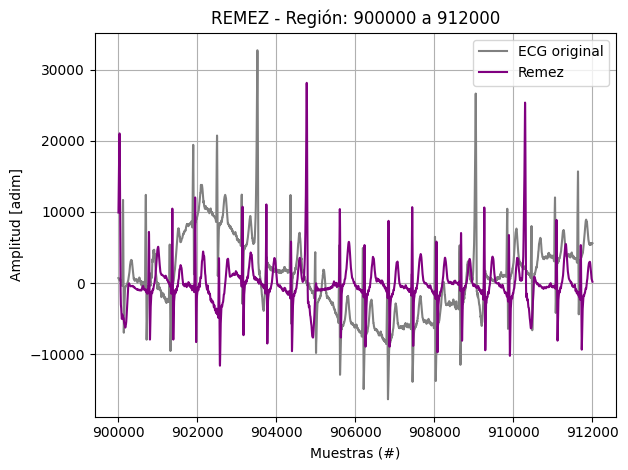

In [34]:
#VER GRAFICOS
ecg_filtrado_remez = sig.lfilter(Filtro_remez, 1, ecg_one_lead)
visualizar_ecg_por_tipo(
    ecg_original=ecg_one_lead,
    ecg_filtrados=[ecg_filtrado_remez],
    etiquetas=['remez'],
    demora=[0],
    titulo='REMEZ'
)

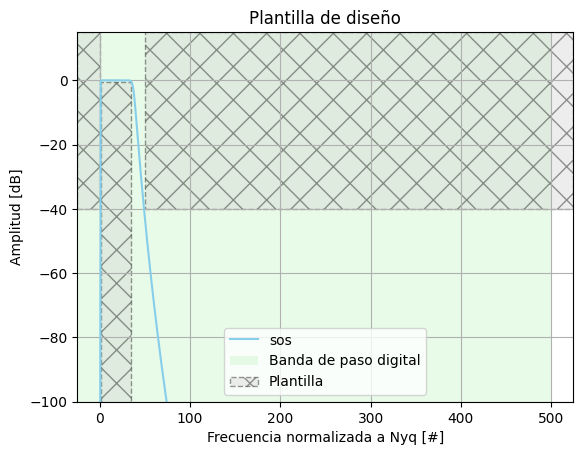

In [8]:
aprox_name = 'butter'
#aprox_name2 = 'cheby1'
# aprox_name = 'cheby2'
#aprox_name = 'ellip'

fs= 1000 #Hz
nyquist=fs/2
fpass = np.array([1.0, 35.0])
ripple = 0.5 # dB
fstop = np.array([.1, 50.])
atenuacion = 40 # dB

sos=sig.iirdesign(fpass,fstop, ripple, atenuacion, ftype=aprox_name, output='sos', fs=fs)

npoints = 1000 
w_rad= np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250)) 
w_rad= np.append(w_rad, np.linspace(40, nyquist, 500, endpoint=True))/ (nyquist* np.pi)
# esto mejoro la resolucion en la subir de 0 a 2 
w, hh = sig.sosfreqz(sos, worN=npoints)  
plt.plot(w/np.pi*fs/2, 20*np.log10(np.abs(hh)+1e-15), label='sos', color='skyblue')  
#1e-15 para no tener problemas de cero
# w/np.pi*fs/2 de cero a nyquist
plt.title('Plantilla de diseño')  
plt.xlabel('Frecuencia normalizada a Nyq [#]')  
plt.ylabel('Amplitud [dB]')  
plt.grid(which='both', axis='both')  
ax = plt.gca()  
# ax.set_xlim([0, 1])  
# ax.set_ylim([-60, 10])  
plot_plantilla(filter_type = 'bandpass', fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs=fs)  
plt.legend()  
plt.show()  

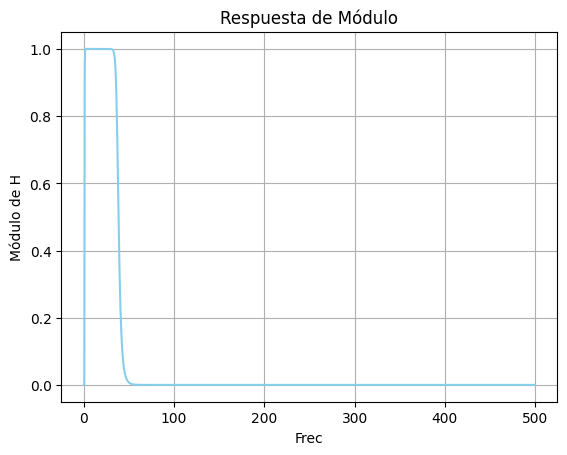

In [44]:
# # %% Respuesta de Modulo

moduloH=np.abs(hh)
plt.plot(w/np.pi*fs/2,moduloH, color='skyblue')
plt.title('Respuesta de Módulo')  
plt.xlabel('Frec')  
plt.ylabel('Módulo de H') 
plt.grid(which='both', axis='both')
plt.show()

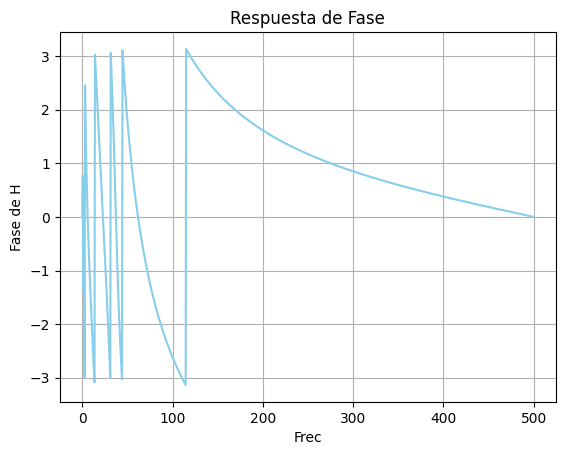

In [46]:
# %% Respuesta de Fase

faseH=np.angle(hh)
plt.plot(w/np.pi*fs/2,faseH, color= 'skyblue')
plt.title('Respuesta de Fase')  
plt.xlabel('Frec')  
plt.ylabel('Fase de H')  
plt.grid(which='both', axis='both')
plt.show()

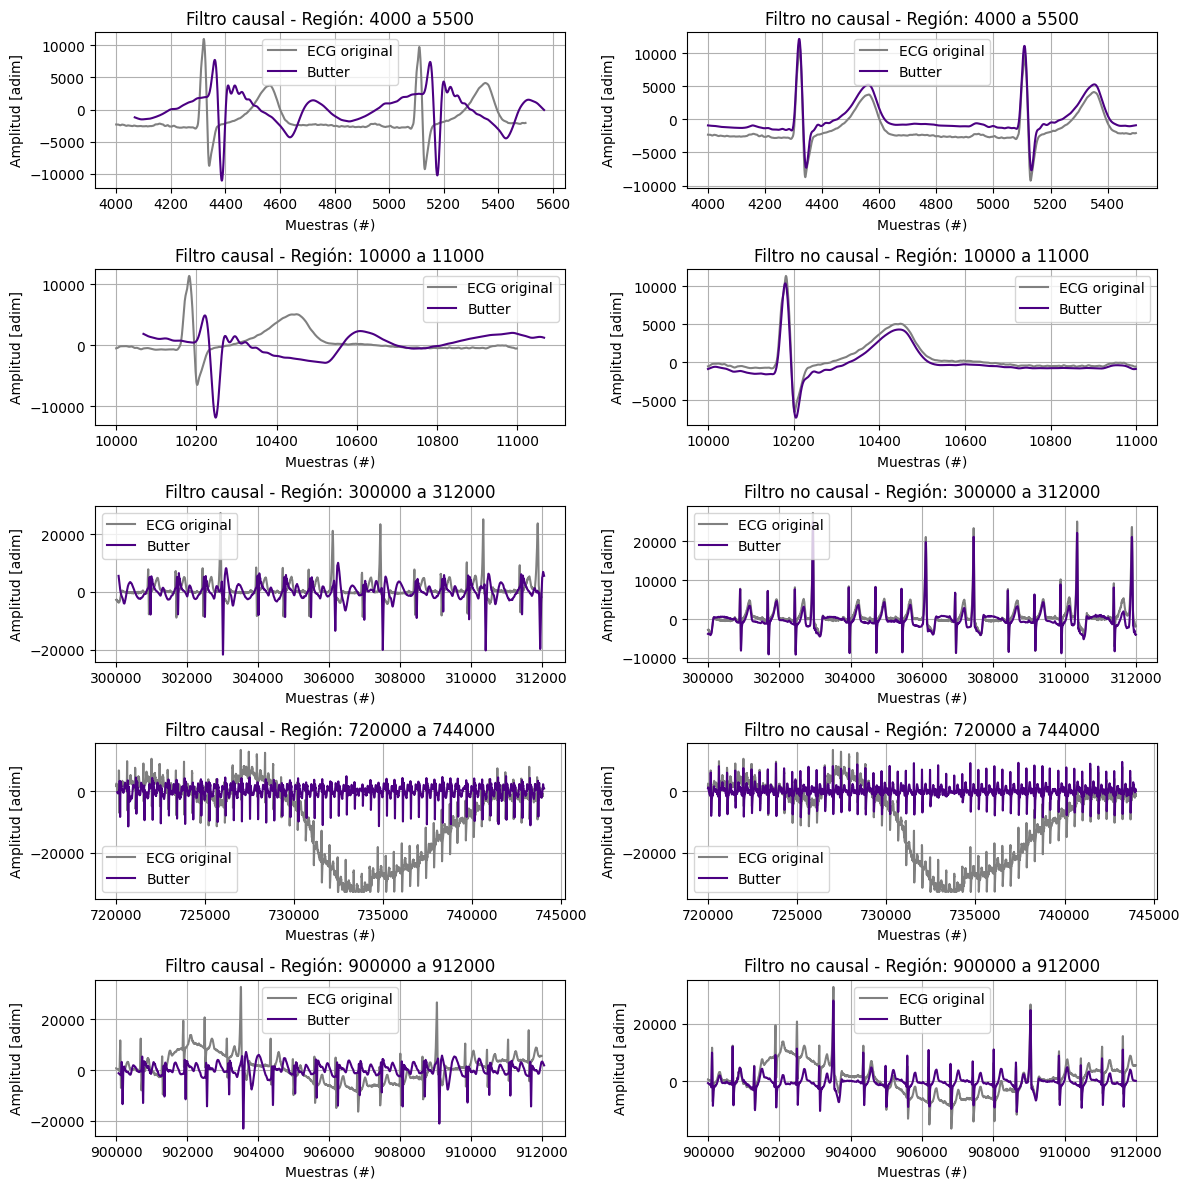

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))  # 5 regiones, 2 métodos
regs_interes = (
    [4000, 5500],
    [10000, 11000],
    np.array([5, 5.2]) * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

# Filtro causal en la columna 0
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_butter], ['butter'],
                        demora=[demora], titulo='Filtro causal',
                        mostrar=0, axs=axs[:, 0], regs_interes=regs_interes)

# Filtro no causal en la columna 1
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_butter_ff], ['butter'],
                        demora=[0], titulo='Filtro no causal',
                        mostrar=0, axs=axs[:, 1], regs_interes=regs_interes)

plt.tight_layout()
plt.show()

In [ ]:

aprox_name = 'butter'
#aprox_name2 = 'cheby1'
# aprox_name = 'cheby2'
#aprox_name = 'ellip'

fs= 1000 #Hz
nyquist=fs/2
fpass = np.array([1.0, 35.0])
ripple = 0.5 # dB
fstop = np.array([.1, 50.])
atenuacion = 40 # dB

sos=sig.iirdesign(fpass,fstop, ripple, atenuacion, ftype=aprox_name, output='sos', fs=fs)

npoints = 1000 
w_rad= np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250)) 
w_rad= np.append(w_rad, np.linspace(40, nyquist, 500, endpoint=True))/ (nyquist* np.pi)
# esto mejoro la resolucion en la subir de 0 a 2 
w, hh = sig.sosfreqz(sos, worN=npoints)  
# moduloH=np.abs(hh, w/np.pi)
# faseH=np.angle(hh)
# plt.plot(w/np.pi*fs/2,faseH)
plt.plot(w/np.pi*fs/2, 20*np.log10(np.abs(hh)+1e-15), label='sos')  
#1e-15 para no tener problemas de cero
# w/np.pi*fs/2 de cero a nyquist
  

plt.title('Plantilla de diseño')  
plt.xlabel('Frecuencia normalizada a Nyq [#]')  
plt.ylabel('Amplitud [dB]')  
plt.grid(which='both', axis='both')  

ax = plt.gca()  
# ax.set_xlim([0, 1])  
# ax.set_ylim([-60, 10])  

plot_plantilla(filter_type = 'bandpass', fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion)  
plt.legend()  
plt.show()





# FILTRADO
# Cargar datos
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
# Plot señal original
# plt.figure()
# plt.plot(ecg_one_lead)
# plt.title('ECG Original')
# plt.show()

# Filtrado con el filtro definido (suponiendo sos ya definido)
ecg_filtrado = sig.sosfiltfilt(sos, ecg_one_lead, axis=0)
demora=0
fig_dpi=150
#%%

#fijate si un latido se ve que hay pequenas diferencias entre las senales no se puede deber a fase porque ya hicimos filtfilt filtrado bidireccional 
# trade off podrias agrandar un poco mas la banda de paso para que la atenuacion no sea tan abrupta

